In [4]:
!pip install grad_cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad_cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=43d7e8db4d618bd8497440a3f94e80bf2d1735eb8b41a27e9228b12ced1d690a
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad_cam


Found TP? True | Found FN? True


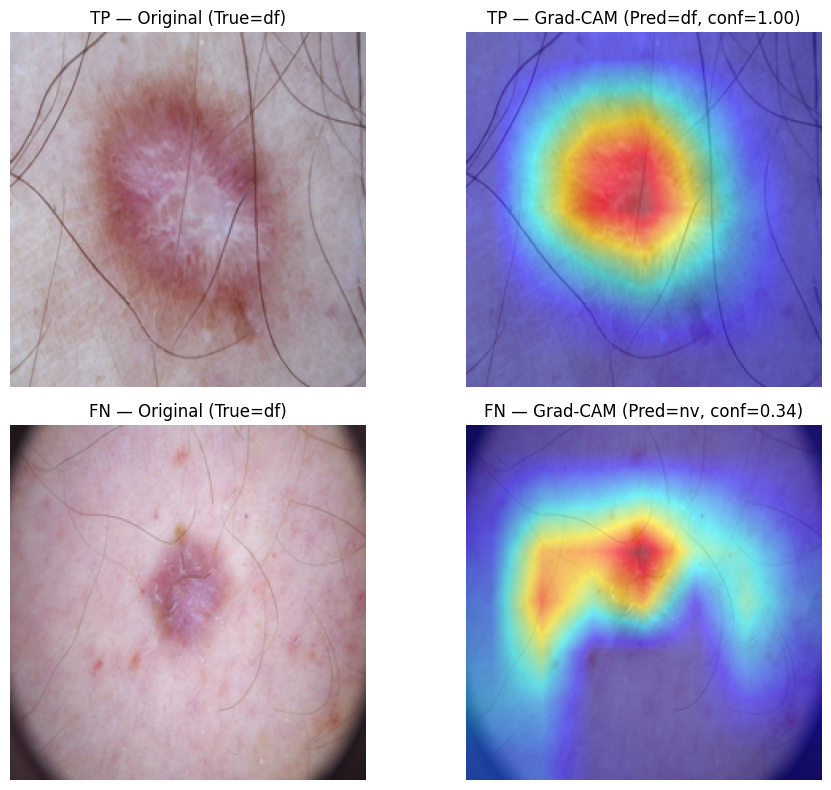

In [22]:
import torch, torch.nn as nn, pandas as pd, numpy as np, matplotlib.pyplot as plt
from torchvision.models import resnet18
import torchvision.transforms as T
from pathlib import Path
from PIL import Image

class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class  = {i:c for i,c in enumerate(classes)}
assert "df" in class_to_idx, "'df' class not found in val_df['dx']"
df_idx = class_to_idx["df"]

DATASET_DIR = Path("/kaggle/input/skin-cancer-mnist-ham10000")
if not DATASET_DIR.exists():
    import kagglehub
    DATASET_DIR = Path(kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000"))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = (224, 224)
TARGET_CLASS = "df"
CKPT = "model_weights.pt"

meta = pd.read_csv(DATASET_DIR / "HAM10000_metadata.csv")
all_jpgs = {p.stem: str(p) for p in DATASET_DIR.rglob("*.jpg")}
meta["path"] = meta["image_id"].map(all_jpgs.get)
val_df = meta.dropna(subset=["path"]).reset_index(drop=True)

classes = sorted(val_df["dx"].unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
target_idx = class_to_idx[TARGET_CLASS]
tfm = T.Compose([
    T.Resize(INPUT_SIZE),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


#model: ResNet18 + (Dropout, Linear)
sd = torch.load(CKPT, map_location=DEVICE)
if isinstance(sd, dict) and "state_dict" in sd and isinstance(sd["state_dict"], dict):
    sd = sd["state_dict"]
sd = {k.replace("module.",""): v for k,v in sd.items()}  # strip DDP

model = resnet18(weights=None)
model.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(model.fc.in_features, len(classes)))

if "fc.weight" in sd and "fc.1.weight" not in sd:
    sd["fc.1.weight"] = sd.pop("fc.weight"); sd["fc.1.bias"] = sd.pop("fc.bias")
model.load_state_dict(sd, strict=False)
model = model.to(DEVICE).eval()


@torch.inference_mode()
def pred_idx_conf(pil):
    x = tfm(pil).unsqueeze(0).to(DEVICE)
    pr = torch.softmax(model(x), 1)[0]
    i = int(torch.argmax(pr))
    return i, float(pr[i])



from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

def cam_overlay(pil, cls_idx):
    rgb = np.array(pil.resize(INPUT_SIZE), dtype=np.float32)/255.0
    g = cam(input_tensor=tfm(pil).unsqueeze(0).to(DEVICE),
            targets=[ClassifierOutputTarget(int(cls_idx))])[0]
    return show_cam_on_image(rgb, g, use_rgb=True)

#true positive and fasle negative
tp = None
fn = None

df_rows = val_df[val_df["dx"] == "df"].sample(frac=1.0, random_state=42)
for _, row in df_rows.iterrows():
    try:
        pil = open_pil(row["path"])
    except Exception:
        continue
    x = to_tensor(pil)
    try:
        y_pred_idx, conf = predict(x)
    except Exception:
        continue

    if y_pred_idx == df_idx and tp is None:
        overlay = gradcam_overlay(pil, df_idx)
        tp = (pil, overlay, conf)
    elif y_pred_idx != df_idx and fn is None:
        overlay = gradcam_overlay(pil, y_pred_idx)
        fn = (pil, overlay, idx_to_class.get(y_pred_idx, f"idx={y_pred_idx}"), conf)

    if tp is not None and fn is not None:
        break

print(f"Found TP? {tp is not None} | Found FN? {fn is not None}")


fig, axes = plt.subplots(2, 2, figsize=(10, 8))

def show_pair(axL, axR, pil_img, overlay, left_title, right_title):
    axL.imshow(pil_img.resize(INPUT_SIZE)); axL.set_title(left_title); axL.axis("off")
    axR.imshow(overlay); axR.set_title(right_title); axR.axis("off")

# Row 1 — TP
if tp is not None:
    pil, overlay, conf = tp
    show_pair(
        axes[0,0], axes[0,1],
        pil, overlay,
        "TP — Original (True=df)",
        f"TP — Grad-CAM (Pred=df, conf={conf:.2f})"
    )
else:
    axes[0,0].axis("off"); axes[0,1].axis("off"); axes[0,0].set_title("No TP found")

# Row 2 — FN
if fn is not None:
    pil, overlay, pred_name, conf = fn
    show_pair(
        axes[1,0], axes[1,1],
        pil, overlay,
        "FN — Original (True=df)",
        f"FN — Grad-CAM (Pred={pred_name}, conf={conf:.2f})"
    )
else:
    axes[1,0].axis("off"); axes[1,1].axis("off"); axes[1,0].set_title("No FN found")

plt.tight_layout()
plt.show()


In [23]:
!pip install lime

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

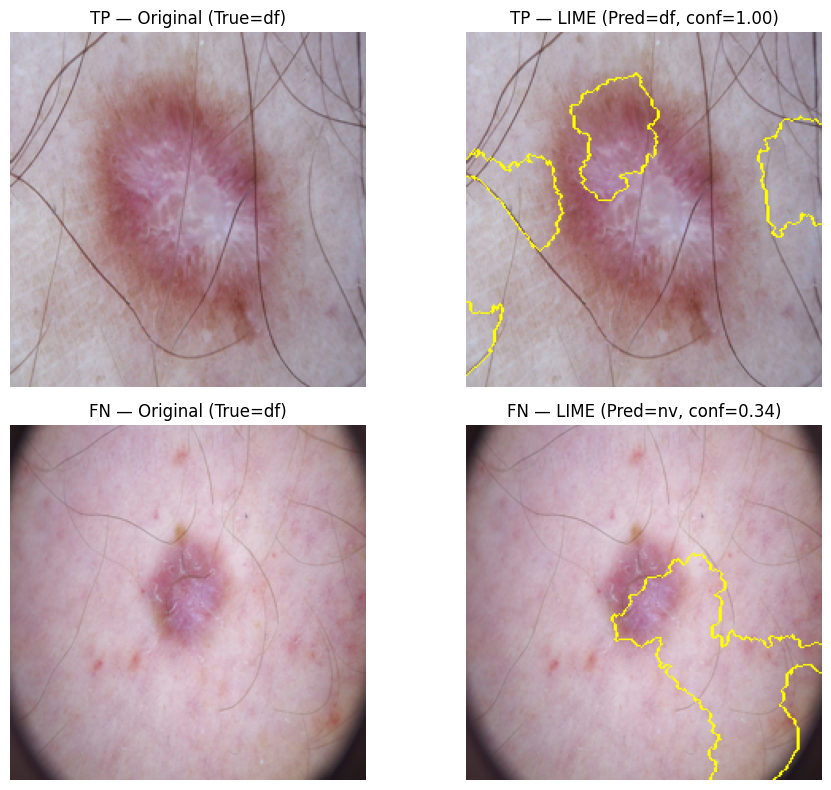

In [24]:
import numpy as np, matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

@torch.inference_mode()
def classifier_fn(np_batch):

    if np_batch.dtype != np.float32:
        np_batch = np_batch.astype(np.float32)
    if np_batch.max() > 1.0:
        np_batch = np_batch / 255.0

    tensors = []
    for img in np_batch:
        pil_like = Image.fromarray((img * 255).astype(np.uint8))
        tensors.append(transform(pil_like))
    x = torch.stack(tensors, dim=0).to(DEVICE)
    probs = torch.softmax(model(x), dim=1).detach().cpu().numpy()
    return probs

explainer = lime_image.LimeImageExplainer()

def lime_mask(pil_img, label_for_explanation, positive_only=True, num_features=5, hide_rest=False):
    img_np = np.array(pil_img.resize(INPUT_SIZE))
    explanation = explainer.explain_instance(
        image=img_np,
        classifier_fn=classifier_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        label=int(label_for_explanation),
        positive_only=positive_only,
        hide_rest=hide_rest,
        num_features=num_features,
        min_weight=0.0
    )
    return temp, mask

fig, axes = plt.subplots(2, 2, figsize=(10, 8))



if tp:
    pil, _, conf = tp
    temp, mask = lime_mask(pil, target_idx, positive_only=True, num_features=5, hide_rest=False)
    axes[0,0].imshow(pil.resize(INPUT_SIZE)); axes[0,0].set_title(f"TP — Original (True={classes[target_idx]})"); axes[0,0].axis("off")
    axes[0,1].imshow(mark_boundaries(temp/255.0, mask)); axes[0,1].set_title(f"TP — LIME (Pred={classes[target_idx]}, conf={conf:.2f})"); axes[0,1].axis("off")
else:
    axes[0,0].axis("off"); axes[0,1].axis("off"); axes[0,0].set_title("No TP found")


if fn:
    pil, _, pred_name, conf = fn
    pred_idx = classes.index(pred_name)
    temp, mask = lime_mask(pil, pred_idx, positive_only=True, num_features=5, hide_rest=False)
    axes[1,0].imshow(pil.resize(INPUT_SIZE)); axes[1,0].set_title(f"FN — Original (True={classes[target_idx]})"); axes[1,0].axis("off")
    axes[1,1].imshow(mark_boundaries(temp/255.0, mask)); axes[1,1].set_title(f"FN — LIME (Pred={pred_name}, conf={conf:.2f})"); axes[1,1].axis("off")
else:
    axes[1,0].axis("off"); axes[1,1].axis("off"); axes[1,0].set_title("No FN found")

plt.tight_layout(); plt.show()
